In [1]:
from utils import gpu_cpu_test
gpu_cpu_test()
#checking gpu|cpu computation abilities

TF version - 1.8.0
Default GPU Device: /device:GPU:0
---------- -----------
Using device info: 
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4456221601323706802
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3225105203
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2520851364597846146
physical_device_desc: "device: 0, name: GeForce GTX 960M, pci bus id: 0000:01:00.0, compute capability: 5.0"
]


In [1]:
#import libraries
import numpy as np
import matplotlib.pyplot as plt
from dataset_getter import open_dataset
from utils import save_history

from keras.layers import Input, Dense, Convolution2D, MaxPooling2D, UpSampling2D,BatchNormalization
from keras.models import Model, load_model
from keras import backend as K
import easygui

Using TensorFlow backend.


In [83]:
#load and prepare data
n_channels=12
ecg_segment_len = 256
x_train, x_test, _, _ = open_dataset()
x_train = np.swapaxes(x_train, 1, 3)
x_test = np.swapaxes(x_test, 1, 3)
x_train = x_train[:, 0:ecg_segment_len, :, : ]
x_test = x_test[:, 0:ecg_segment_len, :, :]
print("после свопа со срезом x_test - " + str(x_test.shape))
print("после свопа со срезом x_train - " + str(x_train.shape))
#slice 5000 -> 512

загружаем 2д-датасет из файла C:\Users\milom\YandexDisk\Documents\Programming\Projects\Python\Deep Learning\DL_ECG\all_datasets_here\ELECTRIC_AXIS.pkl
409  записей 
y_train  имеет форму (274, 5)
x_train  имеет форму (274, 12, 1, 5000)
x_test   имеет форму (135, 12, 1, 5000)
y_test   имеет форму (135, 5)
после свопа со срезом x_test - (135, 256, 1, 12)
после свопа со срезом x_train - (274, 256, 1, 12)


In [84]:
#input ecg
input_data=Input(shape=(ecg_segment_len, 1, n_channels))

In [98]:
#convolitonal layers
#1l
x=Convolution2D(32,kernel_size=(3,1),strides=(1,1), activation='elu',padding='same')(input_data)
x=MaxPooling2D((2,2), padding='same')(x)
#2l
x=Convolution2D(64, kernel_size=(3,1),strides=(1,1),activation='elu', padding='same')(x)
encoded=MaxPooling2D((2,2), padding='same')(x)
#3l
x=Convolution2D(128, kernel_size=(3,1),strides=(1,1),activation='elu', padding='same')(x)
x=MaxPooling2D((2,2), padding='same')(x)
#4l
x=Convolution2D(256, kernel_size=(3,1),strides=(1,1),activation='linear', padding='same')(x)
encoded=MaxPooling2D((2,2), padding='same')(x)


In [99]:
#deconvolitonal layers
#1dl
x=Convolution2D(256,kernel_size=(3,1),strides=(1,1),activation='elu',padding='same')(encoded)
x=UpSampling2D((2,1))(x)
#2dl
x=Convolution2D(128,kernel_size=(3,1),strides=(1,1),activation='elu',padding='same')(x)
x=UpSampling2D((2,1))(x)
#3dl
x=Convolution2D(64,kernel_size=(3,1),strides=(1,1),activation='elu',padding='same')(x)
decoded=UpSampling2D((1,1))(x)
#4l
x=Convolution2D(32,kernel_size=(3,1),strides=(1,1),activation='elu',padding='same')(x)
x=UpSampling2D((2,1))(x)
#decoded layer
x=Convolution2D(12,kernel_size=(1,1),strides=(1,1), activation='linear',padding='same')(x)
decoded=UpSampling2D((1,1))(x)


In [100]:
caterpillar=Model(input_data,decoded)
caterpillar.summary()
caterpillar.compile(optimizer='nadam',loss='mean_squared_logarithmic_error')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 256, 1, 12)        0         
_________________________________________________________________
conv2d_135 (Conv2D)          (None, 256, 1, 32)        1184      
_________________________________________________________________
max_pooling2d_54 (MaxPooling (None, 128, 1, 32)        0         
_________________________________________________________________
conv2d_136 (Conv2D)          (None, 128, 1, 64)        6208      
_________________________________________________________________
conv2d_137 (Conv2D)          (None, 128, 1, 128)       24704     
_________________________________________________________________
max_pooling2d_56 (MaxPooling (None, 64, 1, 128)        0         
_________________________________________________________________
conv2d_138 (Conv2D)          (None, 64, 1, 256)        98560     
__________

In [101]:
train_history=caterpillar.fit(x_train,x_train, epochs=50,batch_size=20,shuffle=True,validation_data=(x_test,x_test),callbacks=None)

Train on 274 samples, validate on 135 samples
Epoch 1/50
274/274 [==============================] - 3s 10ms/step - loss: 2.6006 - val_loss: 2.2094
Epoch 2/50
274/274 [==============================] - 0s 1ms/step - loss: 1.6583 - val_loss: 1.5208
Epoch 3/50
274/274 [==============================] - 0s 1ms/step - loss: 1.2728 - val_loss: 1.1125
Epoch 4/50
274/274 [==============================] - 0s 1ms/step - loss: 0.9065 - val_loss: 0.8750
Epoch 5/50
274/274 [==============================] - 0s 1ms/step - loss: 0.7528 - val_loss: 0.7937
Epoch 6/50
274/274 [==============================] - 0s 1ms/step - loss: 0.7078 - val_loss: 0.7464
Epoch 7/50
274/274 [==============================] - 0s 1ms/step - loss: 0.5998 - val_loss: 0.9176
Epoch 8/50
274/274 [==============================] - 0s 1ms/step - loss: 0.6854 - val_loss: 0.9015
Epoch 9/50
274/274 [==============================] - 0s 1ms/step - loss: 0.5710 - val_loss: 0.7398
Epoch 10/50
274/274 [==============================] 

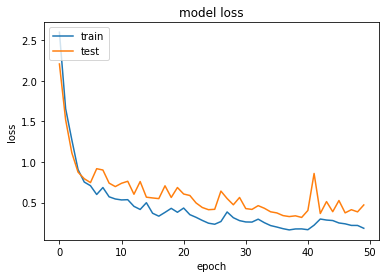

In [102]:
save_history(train_history,'ctp2')
model_name='ae_'
caterpillar.save(model_name+'ctp2.h5')
caterpillar.save_weights(model_name+'ctp2_weights.h5')

In [26]:
#Visualization test
def show_reconstruction_by_ae(ecg_sample, name):
    filepath = easygui.fileopenbox("выберите файл с обученной моделью .h5")
    trained_model = load_model(filepath)

    ecg_sample = np.array([ecg_sample])
    prediction = trained_model.predict(ecg_sample)

    draw_reconstruction_to_png(ecg_sample[0],prediction[0], name)

def get_ecg_test_sample(num_patient):
    sample = x_test[num_patient,:,:,:]
    print("форма тензора с экг: "+ str(sample.shape))
    return sample

def draw_reconstruction_to_png(ecg_true, ecg_predicted, png_filename):
    """
    :param ecg_true: истинная экг
    :param ecg_predicted: предсказанное
    :param png_filename: имя для файла с картинкой
    :return:
    """
    ecg_true = reshape_ecg_tensor(ecg_true)
    ecg_predicted = reshape_ecg_tensor(ecg_predicted)

    assert ecg_true.shape == ecg_predicted.shape

    len_of_time = len(ecg_true[0])
    t = [i for i in range(len_of_time)]


    rows = len(ecg_true)  # кол-во каналов
    cols = 2              # true и predicted - 2 столбика
    f, axarr = plt.subplots(nrows=rows, ncols=cols, sharex=True, sharey=True)
    for i in range(rows):
        true_i_chanel = ecg_true[i]
        predicted_i_chanel = ecg_predicted[i]
        axarr[i, 0].plot(t, true_i_chanel)
        axarr[i, 1].plot(t, predicted_i_chanel)


    plt.savefig(png_filename+".png")

def reshape_ecg_tensor(ecg):
    # превратим (252, 1, 12) в (12, 252)
    print ("форма тезора с экг =  " + str(ecg.shape))
    ecg = ecg[:,0,:]
    ecg = np.transpose(ecg)
    print ("форма тезора с экг (после напильника) =" + str(ecg))
    return ecg

форма тензора с экг: (256, 1, 12)
форма тезора с экг =  (256, 1, 12)
форма тезора с экг (после напильника) =[[ -6.02731365  -5.87472343  -5.87472343 ...  -5.87472343  -5.87472343
   -5.87472343]
 [-18.23453117 -18.08194095 -18.08194095 ... -27.23735409 -27.23735409
  -27.23735409]
 [-12.13092241 -12.13092241 -12.13092241 ... -21.28633555 -21.28633555
  -21.28633555]
 ...
 [  3.12809949   3.12809949   3.12809949 ...  -5.87472343  -5.87472343
   -5.87472343]
 [-24.33813993 -24.18554971 -24.18554971 ... -14.11459525 -13.50423438
  -12.74128328]
 [-30.44174868 -30.28915846 -30.28915846 ... -15.03013657 -15.03013657
  -15.03013657]]
форма тезора с экг =  (256, 1, 12)
форма тезора с экг (после напильника) =[[ -1.1478072   -1.1478072   -1.6413443  ...  -1.5690049   -0.03338727
   -0.03338727]
 [ -5.863145    -5.863145    -9.138317   ... -14.506965    -9.729921
   -9.729921  ]
 [ -2.7912457   -2.7912457   -5.9019833  ...  -5.8845906   -2.7029054
   -2.7029054 ]
 ...
 [ -3.0090325   -3.0090325 

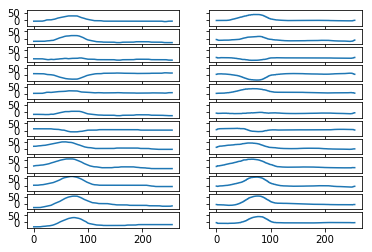

In [103]:
name = "reconstr"
#model = train_canterpillar(name)
ecg_sample = get_ecg_test_sample(num_patient=0)
show_reconstruction_by_ae(ecg_sample, name)